In [2]:
base_path = "/content/drive/My Drive/Github/mtc-device-activation"

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')# Load saved data

Mounted at /content/drive


In [5]:
!apt-get update
!apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 257 kB in 1s (202 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package list

Counts:
  CA-SBL-ANC γ values: 4800000
  SBL γ values:        4800000


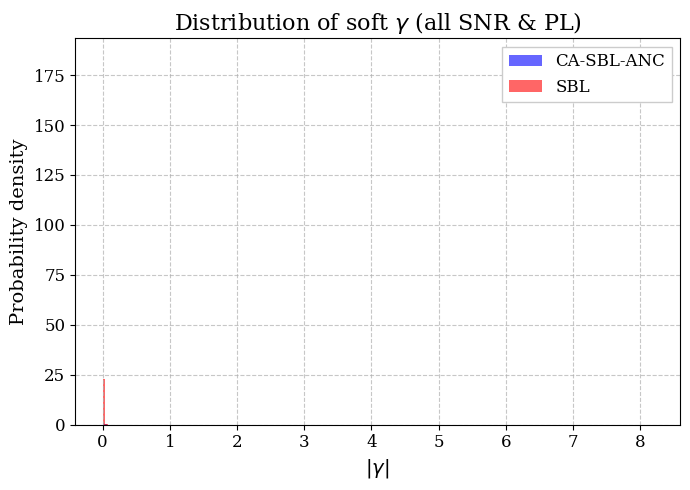

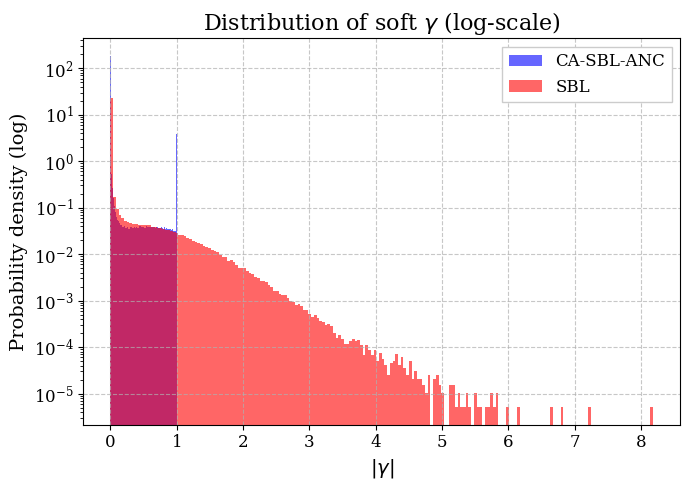

In [6]:
# =====================================================
# EXACT folders/prefixes
# =====================================================
TARGETS = {
    "casbl": [
        # fixed pilot length = 30, varying SNR
        ("snr_db_all_pilot_length_30", "casbl_snr_db_all_pilot_length_30"),
        # fixed SNR = 12 dB, varying PL
        ("snr_db_12_pilot_length_all", "casbl_snr_db_12_pilot_length_all"),
    ],
    "sbl": [
        ("snr_db_all_pilot_length_30", "sbl_snr_db_all_pilot_length_30"),
        ("snr_db_12_pilot_length_all", "sbl_snr_db_12_pilot_length_all"),
    ]
}

NUM_SETS = 5  # sets are saved as *_set_1.npz ... *_set_5.npz

# =========================
# Loading utilities
# =========================
def load_gamma_npz(folder_name, file_prefix, num_sets=5):
    """
    Load gamma_result_all from multiple *_set_i.npz files.
    Returns a list of arrays (each possibly ndarray or object array).
    """
    gs = []
    for i in range(1, num_sets + 1):
        path = f"{base_path}/estimation/{folder_name}/data/{file_prefix}_set_{i}.npz"
        est = np.load(path, allow_pickle=True)
        if "gamma_result_all" not in est.files:
            continue
        gs.append(est["gamma_result_all"])
    return gs

def gamma_any_to_abs_vec(g):
    """
    Convert gamma array (numeric or object) to a 1D |gamma| vector.
    Handles:
      - numeric (S,K,N) -> flatten
      - object (S,K) with each cell (N,) -> flatten all cells
      - complex -> magnitude
    """
    if isinstance(g, np.ndarray) and g.dtype == object and g.ndim == 2:
        S, K = g.shape
        out = []
        for s in range(S):
            for k in range(K):
                v = np.asarray(g[s, k])
                if v.ndim == 0:
                    continue
                v = np.abs(v) if np.iscomplexobj(v) else v.astype(np.float64, copy=False)
                out.append(v.ravel())
        return np.concatenate(out, axis=0) if out else np.array([], dtype=np.float64)
    # numeric path
    g_arr = np.asarray(g)
    g_arr = np.abs(g_arr) if np.iscomplexobj(g_arr) else g_arr.astype(np.float64, copy=False)
    return g_arr.ravel()

def collect_all_gamma(alg_key, targets, num_sets=5):
    """
    For alg_key in {'casbl','sbl'}, loop through known (folder,prefix) pairs,
    load all sets, convert each to |gamma| vector, and concatenate.
    """
    vecs = []
    for folder, prefix in targets:
        gamma_list = load_gamma_npz(folder, prefix, num_sets=num_sets)
        for g in gamma_list:
            vec = gamma_any_to_abs_vec(g)
            if vec.size:
                vecs.append(vec)
    return np.concatenate(vecs, axis=0) if vecs else np.array([], dtype=np.float64)

# =========================
# Aggregate ALL soft-γ across runs
# =========================
gamma_casbl_all = collect_all_gamma("casbl", TARGETS["casbl"], num_sets=NUM_SETS)
gamma_sbl_all   = collect_all_gamma("sbl",   TARGETS["sbl"],   num_sets=NUM_SETS)

print("Counts:")
print("  CA-SBL-ANC γ values:", gamma_casbl_all.size)
print("  SBL γ values:       ", gamma_sbl_all.size)

# =========================
# Plot distributions
# =========================
plt.rcParams.update({
    'font.family': 'serif',
    'text.usetex': False,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'grid.linestyle': '--',
    'grid.alpha': 0.7,
})

# Linear-scale PDF
plt.figure(figsize=(7, 5))
if gamma_casbl_all.size:
    plt.hist(gamma_casbl_all, bins=200, alpha=0.6, density=True, label="CA-SBL-ANC", color="b")
if gamma_sbl_all.size:
    plt.hist(gamma_sbl_all,   bins=200, alpha=0.6, density=True, label="SBL",        color="r")
plt.xlabel(r"$|\gamma|$")
plt.ylabel("Probability density")
plt.title("Distribution of soft $\\gamma$ (all SNR & PL)")
plt.grid(True)
plt.legend(frameon=True, framealpha=1, facecolor='white', fancybox=False)
plt.tight_layout()
plt.show()

# Log-scale PDF (to reveal small tails)
plt.figure(figsize=(7, 5))
if gamma_casbl_all.size:
    plt.hist(gamma_casbl_all, bins=200, alpha=0.6, density=True, label="CA-SBL-ANC", color="b")
if gamma_sbl_all.size:
    plt.hist(gamma_sbl_all,   bins=200, alpha=0.6, density=True, label="SBL",        color="r")
plt.yscale('log')
plt.xlabel(r"$|\gamma|$")
plt.ylabel("Probability density (log)")
plt.title("Distribution of soft $\\gamma$ (log‑scale)")
plt.grid(True)
plt.legend(frameon=True, framealpha=1, facecolor='white', fancybox=False)
plt.tight_layout()
plt.show()

Counts:
  CA-SBL-ANC |γ| samples: 4800000
  SBL        |γ| samples: 4800000


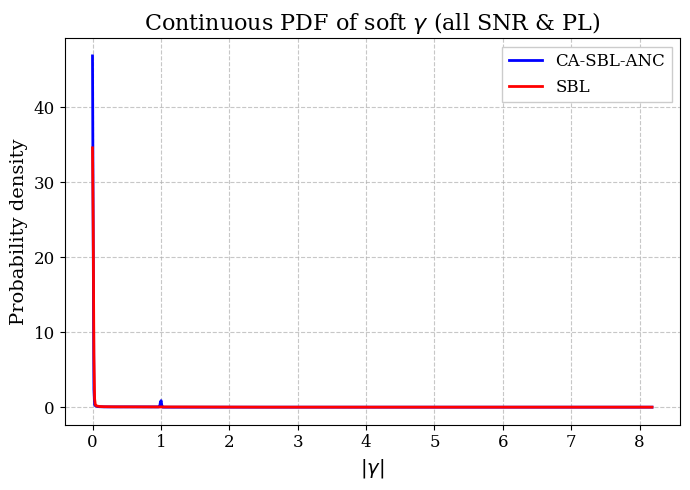

In [7]:
from scipy.stats import gaussian_kde

# === EXACT folders/prefixes ===
TARGETS = {
    "casbl": [
        ("snr_db_all_pilot_length_30", "casbl_snr_db_all_pilot_length_30"),
        ("snr_db_12_pilot_length_all", "casbl_snr_db_12_pilot_length_all"),
    ],
    "sbl": [
        ("snr_db_all_pilot_length_30", "sbl_snr_db_all_pilot_length_30"),
        ("snr_db_12_pilot_length_all", "sbl_snr_db_12_pilot_length_all"),
    ],
    # If you want to include CA-SBL-UC in the CASBL curve too, uncomment these:
    # "casbl_uc": [
    #     ("snr_db_all_pilot_length_30", "casbl_uc_snr_db_all_pilot_length_30"),
    #     ("snr_db_12_pilot_length_all", "casbl_uc_snr_db_12_pilot_length_all"),
    # ],
}

NUM_SETS = 5  # files are *_set_1.npz ... *_set_5.npz

# ---------- Loaders ----------

def gamma_any_to_abs_vec(g):
    """
    Convert gamma array (numeric or object) to a 1D |gamma| vector.
    Handles:
      - numeric (S,K,N) -> flatten
      - object (S,K) with each cell (N,) -> flatten all
      - complex -> magnitude
    """
    if isinstance(g, np.ndarray) and g.dtype == object and g.ndim == 2:
        S, K = g.shape
        out = []
        for s in range(S):
            for k in range(K):
                v = np.asarray(g[s, k])
                if v.ndim == 0:
                    continue
                v = np.abs(v) if np.iscomplexobj(v) else v.astype(np.float64, copy=False)
                out.append(v.ravel())
        return np.concatenate(out, axis=0) if out else np.array([], dtype=np.float64)
    # numeric path
    g_arr = np.asarray(g)
    g_arr = np.abs(g_arr) if np.iscomplexobj(g_arr) else g_arr.astype(np.float64, copy=False)
    return g_arr.ravel()

def load_all_gamma_for_alg(alg_key, targets, num_sets=5):
    """
    For alg_key ('casbl' or 'sbl'), loop over (folder, prefix) targets,
    load *_set_i.npz, extract gamma_result_all, convert to |gamma|, concat.
    """
    vecs = []
    for folder, prefix in targets:
        for i in range(1, num_sets + 1):
            path = f"{base_path}/estimation/{folder}/data/{prefix}_set_{i}.npz"
            est = np.load(path, allow_pickle=True)
            if "gamma_result_all" not in est.files:
                continue
            vec = gamma_any_to_abs_vec(est["gamma_result_all"])
            if vec.size:
                vecs.append(vec)
    return np.concatenate(vecs, axis=0) if vecs else np.array([], dtype=np.float64)

# ---------- Aggregate ALL γ across runs ----------

gamma_casbl_all = load_all_gamma_for_alg("casbl", TARGETS["casbl"], num_sets=NUM_SETS)
gamma_sbl_all   = load_all_gamma_for_alg("sbl",   TARGETS["sbl"],   num_sets=NUM_SETS)

print("Counts:")
print("  CA-SBL-ANC |γ| samples:", gamma_casbl_all.size)
print("  SBL        |γ| samples:", gamma_sbl_all.size)

# Optional: include CA-SBL-UC in the CASBL curve as well
# gamma_casbl_uc_all = load_all_gamma_for_alg("casbl_uc", TARGETS["casbl_uc"], num_sets=NUM_SETS)
# if gamma_casbl_uc_all.size:
#     gamma_casbl_all = np.concatenate([gamma_casbl_all, gamma_casbl_uc_all], axis=0)
#     print("  (including CA-SBL-UC) New CA-SBL |γ| samples:", gamma_casbl_all.size)

# ---------- Build continuous PDFs via KDE ----------
# Safety: guard against empty arrays
if gamma_casbl_all.size == 0 or gamma_sbl_all.size == 0:
    raise ValueError("One of the gamma arrays is empty. Check paths/prefixes and rerun.")

# KDEs (area under curve = 1)
kde_casbl = gaussian_kde(gamma_casbl_all)
kde_sbl   = gaussian_kde(gamma_sbl_all)

# Choose a plot range that covers both distributions, with small margins
xmin = min(gamma_casbl_all.min(), gamma_sbl_all.min())
xmax = max(gamma_casbl_all.max(), gamma_sbl_all.max())
# Clip extremes (optional): comment out if you want full range
# p_lo, p_hi = 0.0, 99.9
# xmin = min(np.percentile(gamma_casbl_all, p_lo), np.percentile(gamma_sbl_all, p_lo))
# xmax = max(np.percentile(gamma_casbl_all, p_hi), np.percentile(gamma_sbl_all, p_hi))

x_vals = np.linspace(xmin, xmax, 800)

# ---------- Plot style ----------
plt.rcParams.update({
    'font.family': 'serif',
    'text.usetex': False,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'grid.linestyle': '--',
    'grid.alpha': 0.7,
})

# Linear-scale continuous PDFs
plt.figure(figsize=(7, 5))
plt.plot(x_vals, kde_casbl(x_vals), label="CA-SBL-ANC", color="b", lw=2)
plt.plot(x_vals, kde_sbl(x_vals),   label="SBL",        color="r", lw=2)
plt.xlabel(r"$|\gamma|$")
plt.ylabel("Probability density")
plt.title("Continuous PDF of soft $\\gamma$ (all SNR & PL)")
plt.grid(True)
plt.legend(frameon=True, framealpha=1, facecolor="white", fancybox=False)
plt.tight_layout()
plt.show()